In [7]:
import scipy.io
import scipy.misc
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

import random
import os
from os import scandir
import warnings
warnings.simplefilter('ignore')

In [8]:
pathA = 'data/apple2orange/trainA'
pathB = 'data/apple2orange/trainB'

def read_path(path):
    pathes = []
    for file in scandir(path):
        if file.name.endswith('.jpg') and file.is_file():
            pathes.append(file.path)
    
    return pathes

pathesA = read_path(pathA)
pathesB = read_path(pathB)

In [9]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

def load_img(path):
    image = scipy.misc.imread(path)
    image = scipy.misc.imresize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
    return image
    
def load_data(pathes):
    datas = []
    for path in pathes:
        img = load_img(path)
        datas.append(img)
    
    return datas

dataA = load_data(pathesA)
dataB = load_data(pathesB)

In [10]:
def lrelu(x, leak=0.2, name="lrelu", alt_relu_impl=False):

    with tf.variable_scope(name):
        if alt_relu_impl:
            f1 = 0.5 * (1 + leak)
            f2 = 0.5 * (1 - leak)
            # lrelu = 1/2 * (1 + leak) * x + 1/2 * (1 - leak) * |x|
            return f1 * x + f2 * abs(x)
        else:
            return tf.maximum(x, leak*x)

def instance_norm(x):

    with tf.variable_scope("instance_norm"):
        epsilon = 1e-5
        mean, var = tf.nn.moments(x, [1, 2], keep_dims=True)
        scale = tf.get_variable('scale',[x.get_shape()[-1]], 
            initializer=tf.truncated_normal_initializer(mean=1.0, stddev=0.02))
        offset = tf.get_variable('offset',[x.get_shape()[-1]],initializer=tf.constant_initializer(0.0))
        out = scale*tf.div(x-mean, tf.sqrt(var+epsilon)) + offset

        return out


def general_conv2d(inputconv, o_d=64, f_h=7, f_w=7, s_h=1, s_w=1, stddev=0.02, padding="VALID", name="conv2d", do_norm=True, do_relu=True, relufactor=0):
    with tf.variable_scope(name):
        
        conv = tf.contrib.layers.conv2d(inputconv, o_d, f_w, s_w, padding, activation_fn=None, weights_initializer=tf.truncated_normal_initializer(stddev=stddev),biases_initializer=tf.constant_initializer(0.0))
        if do_norm:
            conv = instance_norm(conv)
            # conv = tf.contrib.layers.batch_norm(conv, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, scope="batch_norm")
            
        if do_relu:
            if(relufactor == 0):
                conv = tf.nn.relu(conv,"relu")
            else:
                conv = lrelu(conv, relufactor, "lrelu")

        return conv



def general_deconv2d(inputconv, outshape, o_d=64, f_h=7, f_w=7, s_h=1, s_w=1, stddev=0.02, padding="VALID", name="deconv2d", do_norm=True, do_relu=True, relufactor=0):
    with tf.variable_scope(name):

        conv = tf.contrib.layers.conv2d_transpose(inputconv, o_d, [f_h, f_w], [s_h, s_w], padding, activation_fn=None, weights_initializer=tf.truncated_normal_initializer(stddev=stddev),biases_initializer=tf.constant_initializer(0.0))
        
        if do_norm:
            conv = instance_norm(conv)
            # conv = tf.contrib.layers.batch_norm(conv, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, scope="batch_norm")
            
        if do_relu:
            if(relufactor == 0):
                conv = tf.nn.relu(conv,"relu")
            else:
                conv = lrelu(conv, relufactor, "lrelu")

        return conv
    
def build_resnet_block(inputres, dim, name="resnet"):
    
    with tf.variable_scope(name):

        out_res = tf.pad(inputres, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        out_res = general_conv2d(out_res, dim, 3, 3, 1, 1, 0.02, "VALID","c1")
        out_res = tf.pad(out_res, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        out_res = general_conv2d(out_res, dim, 3, 3, 1, 1, 0.02, "VALID","c2",do_relu=False)
        
        return tf.nn.relu(out_res + inputres)

In [17]:
def save_image(path, image):
    # Output should add back the mean.
    scipy.misc.imsave(path, image)

In [30]:
class cycleGAN(object):
    def __init__(self):
        #initiater
        self.num_epoch = 50
        self.batch_size = 1
        self.log_step = 150
        self.visualize_step = 200
        self.learning_rate_g = 2e-4
        self.learning_rate_d = 1e-4
        
        self.dis_name_1 = 'dis1'
        self.dis_name_2 = 'dis2'
        self.gen_name_1_to_2 = 'gen_1_to_2'
        self.gen_name_2_to_1 = 'gen_2_to_1'

        self.reuse = {
            self.dis_name_1: False,
            self.dis_name_2: False,
            self.gen_name_1_to_2: False,
            self.gen_name_2_to_1: False
        }
        
        self.batch_size = 1
        
        self.lamda = 10

        self.input1 = tf.placeholder(tf.float32, [None, 256, 256, 3])
        self.input2 = tf.placeholder(tf.float32, [None, 256, 256, 3])

        self.real_label = tf.placeholder(tf.float32, [None, 1])
        self.fake_label = tf.placeholder(tf.float32, [None, 1])

        self.is_train = tf.placeholder(tf.bool)

        self._init_ops()
        
    def _discriminator(self, input, scopeName):
        #initiate discriminator for a certain scope

        img_height = 256
        img_width = 256
        img_layer = 3
        img_size = img_height * img_width
        
        ngf = 32
        ndf = 64
        batch_size = self.batch_size

        with tf.variable_scope(scopeName, reuse = self.reuse[scopeName]):
            self.reuse[scopeName] = True
            f = 4

            o_c1 = general_conv2d(input, ndf, f, f, 2, 2, 0.02, "SAME", "c1", do_norm=False, relufactor=0.2)
            o_c2 = general_conv2d(o_c1, ndf*2, f, f, 2, 2, 0.02, "SAME", "c2", relufactor=0.2)
            o_c3 = general_conv2d(o_c2, ndf*4, f, f, 2, 2, 0.02, "SAME", "c3", relufactor=0.2)
            o_c4 = general_conv2d(o_c3, ndf*8, f, f, 1, 1, 0.02, "SAME", "c4",relufactor=0.2)
            o_c5 = general_conv2d(o_c4, 1, f, f, 1, 1, 0.02, "SAME", "c5",do_norm=False,do_relu=False)

            return o_c5

    
    def _generator(self, input, scopeName):
        #initiate generator for a certain scope

        img_height = 256
        img_width = 256
        img_layer = 3
        img_size = img_height * img_width

        ngf = 32
        ndf = 64
        batch_size = self.batch_size
        
        with tf.variable_scope(scopeName, reuse = self.reuse[scopeName]):
            self.reuse[scopeName] = True
            f = 7
            ks = 3

            pad_input = tf.pad(input,[[0, 0], [ks, ks], [ks, ks], [0, 0]], "REFLECT")
            o_c1 = general_conv2d(pad_input, ngf, f, f, 1, 1, 0.02,name="c1")
            o_c2 = general_conv2d(o_c1, ngf*2, ks, ks, 2, 2, 0.02,"SAME","c2")
            o_c3 = general_conv2d(o_c2, ngf*4, ks, ks, 2, 2, 0.02,"SAME","c3")

            o_r1 = build_resnet_block(o_c3, ngf*4, "r1")
            o_r2 = build_resnet_block(o_r1, ngf*4, "r2")
            o_r3 = build_resnet_block(o_r2, ngf*4, "r3")
            o_r4 = build_resnet_block(o_r3, ngf*4, "r4")
            o_r5 = build_resnet_block(o_r4, ngf*4, "r5")
            o_r6 = build_resnet_block(o_r5, ngf*4, "r6")

            o_c4 = general_deconv2d(o_r6, [batch_size,64,64,ngf*2], ngf*2, ks, ks, 2, 2, 0.02,"SAME","c4")
            o_c5 = general_deconv2d(o_c4, [batch_size,128,128,ngf], ngf, ks, ks, 2, 2, 0.02,"SAME","c5")
            o_c5_pad = tf.pad(o_c5,[[0, 0], [ks, ks], [ks, ks], [0, 0]], "REFLECT")
            o_c6 = general_conv2d(o_c5_pad, img_layer, f, f, 1, 1, 0.02,"VALID","c6",do_relu=False)

            # Adding the tanh layer

            out_gen = tf.nn.tanh(o_c6,"t1")


        return out_gen
    
    def _adviserial_loss(self, logits, labels):
        #binary L2 loss
        return tf.reduce_mean(tf.square(logits - labels))
        
    def _cycle_loss(self, logits, labels):
        #L1 loss
        return tf.losses.absolute_difference(logits, labels)/(256*256*3)
    
    def _init_ops(self):
        #operations
        #D1(X1)
        self.real_1_dis = self._discriminator(self.input1, self.dis_name_1)
        #D2(X2)
        self.real_2_dis = self._discriminator(self.input2, self.dis_name_2)
        
        #G21(X2)
        self.generated_1 = self._generator(self.input2, self.gen_name_2_to_1)
        #G12(X1)
        self.generated_2 = self._generator(self.input1, self.gen_name_1_to_2)
        
        #G21(G12(X1))
        self.cycle_fake_1 = self._generator(self.generated_2, self.gen_name_2_to_1)
        #G12(G21(X2))
        self.cycle_fake_2 = self._generator(self.generated_1, self.gen_name_1_to_2)
        
        #D1(G21(X2))
        self.fake_1_dis = self._discriminator(self.generated_1, self.dis_name_1)
        #D2(G12(X1))
        self.fake_2_dis = self._discriminator(self.generated_2, self.dis_name_2)
        
        #variable scope
        self.gen_1_to_2 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,self.gen_name_1_to_2)
        self.gen_2_to_1 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,self.gen_name_2_to_1)
        self.gen_scope = self.gen_1_to_2 + self.gen_2_to_1
        
        self.dis1 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,self.dis_name_1)
        self.dis2 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,self.dis_name_2)
        self.dis_scope = self.dis1 + self.dis2
        
        #loss functions
        gan_loss_1 = self._adviserial_loss(self.fake_1_dis, self.fake_label)
        cycle_loss_1 = self._cycle_loss(self.cycle_fake_1, self.input1)
        self.gen_2_to_1_loss = gan_loss_1 + cycle_loss_1
        
        gan_loss_2 = self._adviserial_loss(self.fake_2_dis, self.fake_label)
        cycle_loss_2 = self._cycle_loss(self.cycle_fake_2, self.input2)
        self.gen_1_to_2_loss = gan_loss_2 + cycle_loss_2
        
        self.gen_loss = self.gen_2_to_1_loss + self.gen_1_to_2_loss
        
        self.dis_loss_1 = self._adviserial_loss(self.real_1_dis, self.real_label)+self._adviserial_loss(self.fake_1_dis, self.fake_label)
            
        self.dis_loss_2 = self._adviserial_loss(self.real_2_dis, self.real_label)+self._adviserial_loss(self.fake_2_dis, self.fake_label)
        
        #optimizers and training step
        dis_optimizer_1 = tf.train.RMSPropOptimizer(self.learning_rate_d)
        self.dis_train_op_1 = dis_optimizer_1.minimize(self.dis_loss_1, var_list = self.dis1)
        
        dis_optimizer_2 = tf.train.RMSPropOptimizer(self.learning_rate_d)
        self.dis_train_op_2 = dis_optimizer_2.minimize(self.dis_loss_2, var_list = self.dis2)
        
        gen_optimizer = tf.train.RMSPropOptimizer(self.learning_rate_g)
        self.gen_train_op = gen_optimizer.minimize(self.gen_loss, var_list = self.gen_scope)
        
        
    def train(self, sess, data1, data2, batch_size = 0):
        sess.run(tf.global_variables_initializer())
        
        if batch_size > 0:
            self.batch_size = batch_size

        num_train = len(data1)
        step = 0
        
        # smooth the loss curve so that it does not fluctuate too much
        smooth_factor = 0.95
        plot_dis_s = 0
        plot_gen_s = 0
        plot_ws = 0
        
        dis_losses = []
        gen_losses = []
        
        print('start training')
        for epoch in range(self.num_epoch):
            for i in range(num_train // self.batch_size):
                
                step += 1

                input1 = data1[i*self.batch_size:(i+1)*self.batch_size]
                input2 = data2[i*self.batch_size:(i+1)*self.batch_size]
                
                zeros = np.zeros([self.batch_size, 1])
                ones = np.ones([self.batch_size, 1])
                
                feed_dict = {
                    self.input1: input1,
                    self.input2: input2,
                    self.real_label: ones,
                    self.fake_label: zeros,
                    self.is_train: True
                }

                _, dis_loss_1 = sess.run([self.dis_train_op_1, self.dis_loss_1], feed_dict = feed_dict)
                _, dis_loss_2 = sess.run([self.dis_train_op_2, self.dis_loss_2], feed_dict = feed_dict)
                _, gen_loss = sess.run([self.gen_train_op, self.gen_loss], feed_dict = feed_dict)
                
                dis_loss = dis_loss_1 + dis_loss_2

                plot_dis_s = plot_dis_s * smooth_factor + dis_loss * (1 - smooth_factor)
                plot_gen_s = plot_gen_s * smooth_factor + gen_loss * (1 - smooth_factor)
                plot_ws = plot_ws * smooth_factor + (1 - smooth_factor)
                dis_losses.append(plot_dis_s / plot_ws)
                gen_losses.append(plot_gen_s / plot_ws)

                if step % self.log_step == 1:
                    print('Iteration {0}: dis loss = {1:.4f}, gen loss = {2:.4f}'.format(step, dis_loss, gen_loss))
                    generated = sess.run([self.generated_1], feed_dict = {self.input2: [data2[0]]})
                    print(generated[0].shape)
                    generated = generated[0]
                    generated = generated[0]
                    filename = 'output/%d.png' % (step)
                    save_image(filename, generated)
                    
                    plt.imshow(scipy.misc.imread('output/%d.png' % (step)))
                    plt.show()

            plt.plot(dis_losses)
            plt.title('discriminator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()

            plt.plot(gen_losses)
            plt.title('generator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()     

start training
Iteration 1: dis loss = 5259.7666, gen loss = 28555.8047
(1, 256, 256, 3)


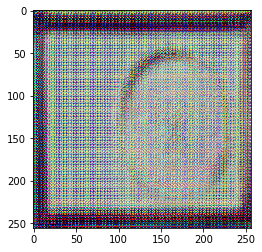

Iteration 151: dis loss = 2528.5742, gen loss = 923.0789
(1, 256, 256, 3)


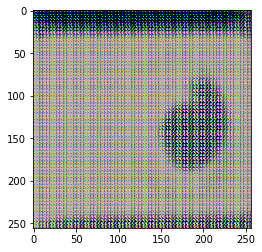

Iteration 301: dis loss = 513.4396, gen loss = 610.0185
(1, 256, 256, 3)


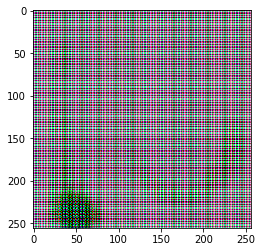

Iteration 451: dis loss = 314.3735, gen loss = 388.7382
(1, 256, 256, 3)


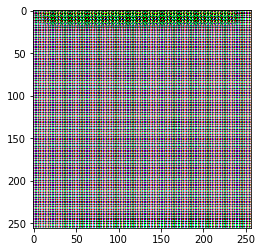

Iteration 601: dis loss = 968.1912, gen loss = 1080.8962
(1, 256, 256, 3)


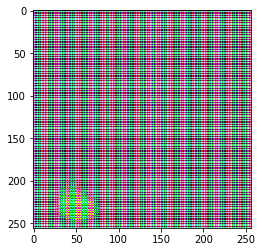

Iteration 751: dis loss = 1066.0352, gen loss = 333.6894
(1, 256, 256, 3)


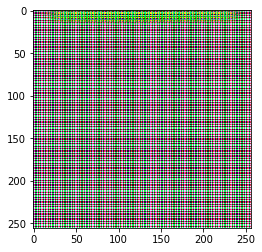

Iteration 901: dis loss = 494.5864, gen loss = 576.9771
(1, 256, 256, 3)


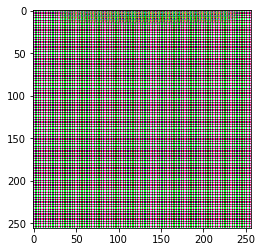

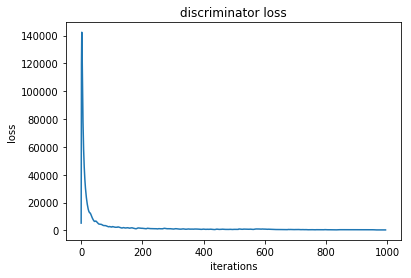

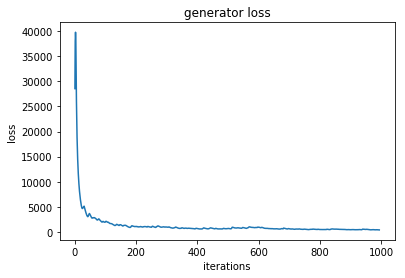

Iteration 1051: dis loss = 466.4286, gen loss = 539.5258
(1, 256, 256, 3)


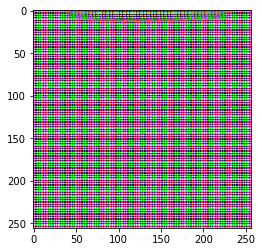

Iteration 1201: dis loss = 275.3190, gen loss = 513.3619
(1, 256, 256, 3)


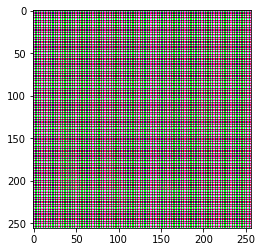

Iteration 1351: dis loss = 216.0224, gen loss = 217.6595
(1, 256, 256, 3)


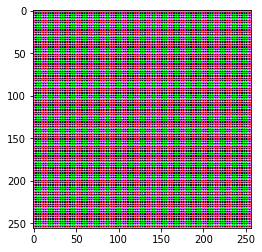

Iteration 1501: dis loss = 214.9904, gen loss = 303.3244
(1, 256, 256, 3)


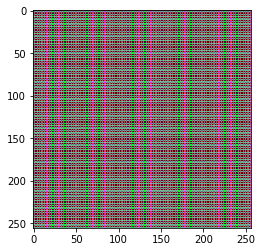

KeyboardInterrupt: 

In [31]:
tf.reset_default_graph()

with tf.Session() as sess:
    cycle_gan = cycleGAN()
    sess.run(tf.global_variables_initializer())
    cycle_gan.train(sess, dataA, dataB)
        
    saver = tf.train.Saver(cycle_gan.gen_scope + cycle_gan.dis_scope)
    saver.save(sess, 'model/dcgan')